In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pkg_resources
import seaborn as sns
import os
import warnings
warnings.filterwarnings(action='once')

Matplotlib is building the font cache; this may take a moment.


In [2]:
import sys
sys.path.append('../')
import ActflowToolbox as actflow
from nltools.utils import get_resource_path
from nltools.file_reader import onsets_to_dm
from nltools.data import Design_Matrix
import statsmodels.api as sm
from sklearn.preprocessing import scale

/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/pkg_resources/__init__.py:1146: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  self, resource_name
/Users/zeynepenkavi/anaconda/envs/py37/l

# Download data

In [ ]:
# import urllib.request
# import tarfile

In [ ]:
# thetarfile = "https://osf.io/s4h8j/download/"
# ftpstream = urllib.request.urlopen(thetarfile)
# thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
# thetarfile.extractall()

In [ ]:
# thetarfile = "https://osf.io/bqp7m/download/"
# ftpstream = urllib.request.urlopen(thetarfile)
# thetarfile = tarfile.open(fileobj=ftpstream, mode="r|gz")
# thetarfile.extractall()

# Basic Parameters

In [3]:
# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

#Task info dictionaries 
conditions_dict={
    "motor": ["cue", "rf", "lf", "rh", "lh"],
    "wm": ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools", "2bk_body", 
           "2bk_faces", "2bk_places", "2bk_tools"],
    "emotion": ["fear", "neut"],
    "gambling": ["win", "loss"],
    "language": ["story", "math"],
    "relational": ["match", "relation"],
    "social": ["mental", "rnd"]}

run_length_dict = {
    "motor": 284,
    "wm": 405,
    "emotion": 176,
    "gambling": 253,
    "language": 316,
    "relational": 232,
    "social": 274}

bold_name_dict = {
    "rest": ["rfMRI_REST1_LR", "rfMRI_REST1_RL", "rfMRI_REST2_LR", "rfMRI_REST2_RL"],
    "motor": ["tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR"],
    "wm": ["tfMRI_WM_RL", "tfMRI_WM_LR"],
    "emotion": ["tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR"],
    "gambling": ["tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR"],
    "language": ["tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR"],
    "relational": ["tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR"],
    "social": ["tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"]}

task_run_dict = {
    "rest": [1,2,3,4],
    "motor": [5,6],
    "wm": [7,8],
    "emotion": [9,10],
    "gambling": [11,12],
    "language": [13, 14],
    "relational": [15, 16],
    "social": [17, 18]}

# Helper Functions

In [40]:
def get_cond_evs(cond_name, task_name, subject, run = 1, hcp_task_dir = './hcp_task'):
    
    bold_name = bold_name_dict[task_name][run-1]
    cond_evs = pd.read_csv('%s/subjects/%s/EVs/%s/%s.txt'%(hcp_task_dir, subject, bold_name, cond_name), sep="\t", header=None)
    cond_evs = cond_evs.rename(columns={0: "Onset", 1: "Duration", 2: "amplitude"})
    cond_evs = cond_evs.drop(columns=['amplitude'])
    cond_evs['Stim'] = cond_name
    
    return cond_evs

def get_run_evs(subject, task_name, run = 1):
    
    conditions = conditions_dict[task_name]
    evs = pd.DataFrame()
    for cond in conditions:
        cond_evs = get_cond_evs(cond, task_name, subject, run)
        evs = evs.append(cond_evs)
    
    evs = evs.sort_values(by="Onset") 
    return evs

def run_evs_to_dm(run_evs, task_name, TR=.72, convolve = True, add_poly = 2, dct_basis=False):

    sampling_freq = 1./TR
    run_length = run_length_dict[task_name]
    dm = onsets_to_dm(run_evs, sampling_freq=sampling_freq, run_length=run_length, sort=True, add_poly=add_poly)
    
    if convolve: 
        dm = dm.convolve()
    
    if dct_basis:
        dm = dm.add_dct_basis()

    return dm

def get_task_dms(subject, task_name, TR = .72, convolve = True, add_poly = 2, dct_basis=False):
    
    runs = list(range(1,len(task_run_dict[task_name])+1))
    task_dm = Design_Matrix(sampling_freq=1./TR)
    
    for run in runs:
        run_evs = get_run_evs(subject=subject, task_name=task_name, run=run)
        run_dm = run_evs_to_dm(run_evs=run_evs, task_name=task_name, add_poly=add_poly, dct_basis=dct_basis)
        task_dm = task_dm.append(run_dm)
        
    return task_dm

def load_run_timeseries(subject, task_name, run = 1, remove_mean=True, scale_ts=True):
    
    bold_run = task_run_dict[task_name][run-1]
    
    if task_name == 'rest':
        HCP_DIR = './hcp_rest'
    else:
        HCP_DIR='./hcp_task'

    bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
    bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
    ts = np.load(f"{bold_path}/{bold_file}")
    if remove_mean:
        ts -= ts.mean(axis=1, keepdims=True)

    if scale_ts:
    #scales each parcel's timeseries (instead of scaling the bold for one 1 TR from all parcels)
        ts = scale(ts, axis=1)
    
    return ts

def load_task_timeseries(subject, task_name, remove_mean=True, scale_ts = True):
  
    runs = list(range(1,len(task_run_dict[task_name])+1))
    task_ts = np.empty((360, 0))

    for run in runs:
    #since everything is loaded by run and scale_ts is true each parcel should be 
    #scaled for each parcel and for each run separately before being concatenated together
        cur_run_ts = load_run_timeseries(subject=subject, task_name=task_name, run=run)
        task_ts = np.append(task_ts, cur_run_ts, axis=1)
  
    return task_ts

def get_sub_task_resids_and_preds(subject, task_name):
 
    #load task data
    task_ts = load_task_timeseries(subject=subject, task_name=task_name)

    #make design matrix
    task_dm = get_task_dms(subject=subject, task_name=task_name)
    task_regs = task_dm.iloc[:,:len(conditions_dict[task_name])]

    #initialize empty variables to store data in
    run_length = run_length_dict[task_name]
    num_runs = len(task_run_dict[task_name])
    resids = np.empty((0, num_runs*run_length))
    preds = np.empty((0, num_runs*run_length))

    #loop through parcels, run regression and extract residuals
    for parcel in range(len(task_ts)):
        model = sm.OLS(task_ts[parcel], task_dm)
        results = model.fit()
    
        cur_resids = np.array([results.resid])
        resids = np.append(resids, cur_resids, axis=0)
    
        task_coefs = results.params[:len(conditions_dict[task_name])]
        cur_preds = np.zeros(num_runs*run_length)
        for i in range(len(conditions_dict[task_name])):
            cur_preds += task_coefs[i]*task_regs.iloc[:,i]
        cur_preds = np.array(cur_preds).reshape(1, -1)
        preds = np.append(preds, cur_preds, axis=0)

    #save task residuals
    out_dir = './output/residuals/%s'%(task_name)
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    out_fn = '%s_%s_Glasser360Cortical.npy'%(task_name, str(subject))
    np.save(os.path.join(out_dir, out_fn), resids)

    #save task predictions
    out_dir = './output/task_preds/%s'%(task_name)
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)
    out_fn = '%s_%s_Glasser360Cortical.npy'%(task_name, str(subject))
    np.save(os.path.join(out_dir, out_fn), preds)
    
    return resids, preds

def get_sub_fc(subject, task_name, fc_type, base_dir = './output'):
    
    if fc_type == "residual":
        ts_dir = os.path.join(base_dir, 'residuals')
        fc_dir = os.path.join(base_dir, 'residual_fcs')
  
    elif fc_type == "task_preds":
        ts_dir = os.path.join(base_dir, 'task_preds')
        fc_dir = os.path.join(base_dir, 'task_preds_fcs')

    elif fc_type == "rest":
        fc_dir = os.path.join(base_dir, 'rest_fcs')
    
    if not os.path.exists(fc_dir):
        os.makedirs(fc_dir)
        
    if task_name != 'rest':
        ts = np.load(os.path.join(ts_dir, task_name, task_name+'_'+subject+'_Glasser360Cortical.npy'))
    else:
        ts = load_task_timeseries(subject=subject, task_name=task_name)
    
    sub_fc = np.corrcoef(ts)
    out_dir = os.path.join(fc_dir, task_name)
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)
    out_fn = '%s_%s_%s_fc.npy'%(task_name, str(subject), fc_type)
    np.save(os.path.join(out_dir, out_fn), sub_fc)

    return sub_fc

def load_sub_fc(task_name, fc_type, subject, base_dir = './output'):
    
    if fc_type == "residual":
        fc_dir = os.path.join(base_dir, 'residual_fcs')
  
    elif fc_type == "task_preds":
        fc_dir = os.path.join(base_dir, 'task_preds_fcs')

    elif fc_type == "rest":
        fc_dir = os.path.join(base_dir, 'rest_fcs')

    input_dir = os.path.join(fc_dir, task_name)
    fcs_list = os.listdir(input_dir)
    
    fn = '%s_%s_%s_fc.npy'%(task_name, str(subject), fc_type)

    fc = np.load(os.path.join(input_dir, fn))

    return fc

def load_fcs(task_name, fc_type, base_dir = './output'):
    
    if fc_type == "residual":
        fc_dir = os.path.join(base_dir, 'residual_fcs')
  
    elif fc_type == "task_preds":
        fc_dir = os.path.join(base_dir, 'task_preds_fcs')

    elif fc_type == "rest":
        fc_dir = os.path.join(base_dir, 'rest_fcs')

    input_dir = os.path.join(fc_dir, task_name)
    fcs_list = os.listdir(input_dir)
    fcs = np.zeros((360, 360, len(fcs_list)))

    for i, fc in enumerate(fcs_list):
        fcs[:,:,i] = np.load(os.path.join(input_dir, fc))

    return fcs


# Load region information

In [5]:
regions = np.load('./hcp_task/regions.npy').T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

In [6]:
networkpartition_dir = pkg_resources.resource_filename('ActflowToolbox.dependencies', 'ColeAnticevicNetPartition/')
networkdef = np.loadtxt(networkpartition_dir + '/cortex_parcel_network_assignments.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]

In [7]:
network_dict = {1: 'Visual1', 
       2: 'Visual2', 
       3:'Somatomotor',
       4:'Cingulo-Oper',
       5:'Language',
       6:'Default',
       7:'Frontopariet',
       8:'Auditory',
       9:'Posterior-Mu',
       10:'Dorsal-atten',
       11:'Ventral-Mult',
       12:'Orbito-Affec'}

In [ ]:
networkpartition_dir = pkg_resources.resource_filename('ActflowToolbox.dependencies', 'ColeAnticevicNetPartition/')
networkdef = np.loadtxt(networkpartition_dir + '/cortex_parcel_network_assignments.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
netorder=networkorder[:,0]

In [ ]:
network_dict = {1: 'Visual1', 
       2: 'Visual2', 
       3:'Somatomotor',
       4:'Cingulo-Oper',
       5:'Language',
       6:'Default',
       7:'Frontopariet',
       8:'Auditory',
       9:'Posterior-Mu',
       10:'Dorsal-atten',
       11:'Ventral-Mult',
       12:'Orbito-Affec'}

# GLM for all subjects

In [48]:
subjects = os.listdir('./hcp_task/subjects')
subjects = [i for i in subjects if i.startswith('.') == False]
subjects[:10]

['135', '307', '61', '95', '338', '300', '132', '59', '92', '66']

In [ ]:
# task_names = ["emotion", "motor", "gambling"]
# for task_name in task_names:
#   print("Starting residual calculations for task_name: %s"%(task_name))
#   for subject in subjects:
#     sub_res, sub_pred = get_sub_task_resids_and_preds(subject = subject, task_name=task_name)

# FC for rest

In [ ]:
# subjects = os.listdir('./hcp_rest/subjects')
# subjects = [i for i in subjects if i.startswith('.') == False]
# for subject in subjects:
#     sub_res = get_sub_fc(subject = subject, task_name="rest", fc_type="rest")

# FC for task predictions

In [ ]:
# task_names = ["emotion", "motor", "gambling"]
# for task_name in task_names:
#     for subject in subjects:
#         sub_res = get_sub_fc(subject = subject, task_name=task_name, fc_type="task_preds")

# FC for residuals

In [ ]:
# for task_name in task_names:
#     for subject in subjects:
#         sub_res = get_sub_fc(subject = subject, task_name=task_name, fc_type="residual")

# FC comparison figure

In [84]:
fig_dir = './output/plots'

if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

## Residuals state FC plot

In [11]:
resid_fcs = {}
task_names = ["emotion", "motor", "gambling"]
for task_name in task_names:
    print("Loading resid FC for: %s"%(task_name))
    resid_fcs[task_name] = load_fcs(task_name, fc_type='residual')

Loading resid FC for: emotion
Loading resid FC for: motor
Loading resid FC for: gambling


In [12]:
resid_fcs_ave = {}
for task_name in task_names:
    print("Averaging resid FCs for: %s"%(task_name))
    cur_task_fcs = resid_fcs[task_name]
    resid_fcs_ave[task_name] = np.mean(cur_task_fcs[netorder,:,:][:,netorder,:],axis=2)

Averaging resid FCs for: emotion
Averaging resid FCs for: motor
Averaging resid FCs for: gambling


In [87]:
# for i, task_name in enumerate(task_names):
#     fig = actflow.tools.addNetColors(resid_fcs_ave[task_name])
#     figFileName = '%s_resid_fc.png'%(task_name)
#     fig.savefig(os.path.join(fig_dir, figFileName), bbox_inches='tight', format='png', dpi=250)

## Resting state FC plot

In [14]:
rest_fcs = load_fcs(task_name="rest", fc_type="rest")

In [15]:
rest_fcs_ave = np.mean(rest_fcs[netorder,:,:][:,netorder,:],axis=2)

In [16]:
# fig = actflow.tools.addNetColors(rest_fcs_ave)
# figFileName = 'rest_fc.png'
# fig.savefig(os.path.join(fig_dir, figFileName), bbox_inches='tight', format='png', dpi=250)

## Task preds FC plot

In [17]:
task_pred_fcs = {}
task_names = ["emotion", "motor", "gambling"]
for task_name in task_names:
    print("Loading task pred FC for: %s"%(task_name))
    task_pred_fcs[task_name] = load_fcs(task_name, fc_type='task_preds')

Loading resid FC for: emotion
Loading resid FC for: motor
Loading resid FC for: gambling


In [18]:
task_pred_fcs_ave = {}
for task_name in task_names:
    print("Averaging task pred FCs for: %s"%(task_name))
    cur_task_fcs = task_pred_fcs[task_name]
    task_pred_fcs_ave[task_name] = np.mean(cur_task_fcs[netorder,:,:][:,netorder,:],axis=2)

Averaging resid FCs for: emotion
Averaging resid FCs for: motor
Averaging resid FCs for: gambling


In [19]:
# for i, task_name in enumerate(task_names):
#     fig = actflow.tools.addNetColors(task_pred_fcs_ave[task_name])
#     figFileName = '%s_task_fc.png'%(task_name)
#     fig.savefig(os.path.join(fig_dir, figFileName), bbox_inches='tight', format='png', dpi=250)

## Correlations between FC

In [20]:
fc_cor = pd.DataFrame(data = {"fc1":["rest", "rest", "rest", "rest", "rest", "rest",
                                    "emotion_resid", "emotion_resid", "emotion_resid", "emotion_resid", "emotion_resid",
                                     "motor_resid", "motor_resid", "motor_resid", "motor_resid",
                                    "gambling_resid","gambling_resid","gambling_resid",
                                    "emotion_task","emotion_task",
                                     "motor_task",
                                    "emotion_resid", "motor_resid", "gambling_resid", "emotion_task", "motor_task", "gambling_task",
                                    "motor_resid", "gambling_resid","emotion_task", "motor_task", "gambling_task",
                                    "gambling_resid","emotion_task", "motor_task", "gambling_task",
                                    "emotion_task", "motor_task", "gambling_task",
                                    "motor_task", "gambling_task",
                                    "gambling_task"],
                             "fc2":["emotion_resid", "motor_resid", "gambling_resid", "emotion_task", "motor_task", "gambling_task",
                                    "motor_resid", "gambling_resid","emotion_task", "motor_task", "gambling_task",
                                    "gambling_resid","emotion_task", "motor_task", "gambling_task",
                                    "emotion_task", "motor_task", "gambling_task",
                                    "motor_task", "gambling_task",
                                    "gambling_task",
                                   "rest", "rest", "rest", "rest", "rest", "rest",
                                    "emotion_resid", "emotion_resid", "emotion_resid", "emotion_resid", "emotion_resid",
                                     "motor_resid", "motor_resid", "motor_resid", "motor_resid",
                                    "gambling_resid","gambling_resid","gambling_resid",
                                    "emotion_task","emotion_task",
                                     "motor_task",],
                             "cor": np.nan})

In [21]:
fc_cor_dict = {"rest": rest_fcs_ave,
               "emotion_resid": resid_fcs_ave['emotion'], 
               "motor_resid": resid_fcs_ave['motor'], 
               "gambling_resid": resid_fcs_ave['gambling'], 
               "emotion_task": task_pred_fcs_ave['emotion'], 
               "motor_task": task_pred_fcs_ave['motor'], 
               "gambling_task": task_pred_fcs_ave['gambling']}

In [22]:
lind = np.tril_indices(rest_fcs_ave.shape[0], k=-1)
for i in range(fc_cor.shape[0]):
    tmp1 = fc_cor_dict[fc_cor['fc1'].iloc[i]]
    tmp2 = fc_cor_dict[fc_cor['fc2'].iloc[i]]
    fc_cor['cor'].iloc[i] = round(np.corrcoef(tmp1[lind], tmp2[lind])[0, 1], 3)

/Users/zeynepenkavi/anaconda/envs/py37/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [23]:
fc_cor = fc_cor.pivot("fc1", "fc2", "cor")

In [24]:
fc_cor

fc2,emotion_resid,emotion_task,gambling_resid,gambling_task,motor_resid,motor_task,rest
fc1,,,,,,,
emotion_resid,NaN,0.615,0.951,0.465,0.922,0.714,0.871
emotion_task,0.615,NaN,0.455,0.654,0.441,0.454,0.454
gambling_resid,0.951,0.455,NaN,0.355,0.959,0.636,0.892
gambling_task,0.465,0.654,0.355,NaN,0.304,0.385,0.266
motor_resid,0.922,0.441,0.959,0.304,NaN,0.687,0.903
motor_task,0.714,0.454,0.636,0.385,0.687,NaN,0.603
rest,0.871,0.454,0.892,0.266,0.903,0.603,NaN


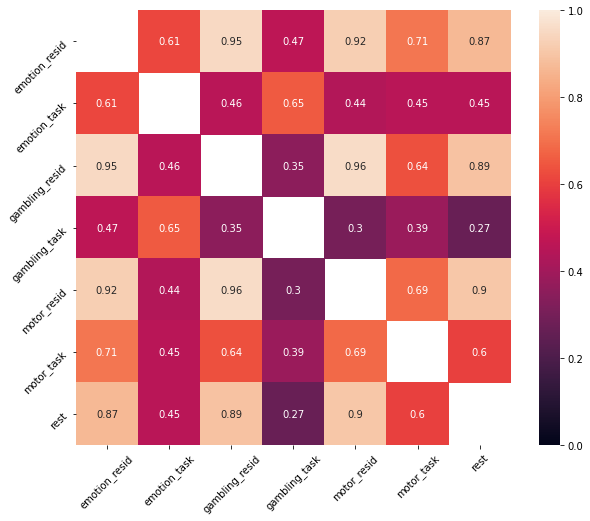

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (10, 8))

sns.heatmap(fc_cor, square=True, vmin = 0, vmax=1, annot= True)

ax.set_ylabel('')    
ax.set_xlabel('')
plt.yticks(rotation=45)
plt.xticks(rotation=45) 
plt.savefig(os.path.join(fig_dir, "fc_cor.png"), dpi = 250, bbox_inches='tight')

In [30]:
plt.savefig(os.path.join(fig_dir, "fc_cor.png"), dpi = 250)

<Figure size 432x288 with 0 Axes>

# Residual - Rest

Task unrelated activity that isn't due to intrinsic fluctuations. Operationalized by the difference between task residual FC and resting FC

In [76]:
resid_rest_fcs = dict.fromkeys(task_names, np.zeros((360, 360, len(subjects))))

In [78]:
for i, subject in enumerate(subjects):
    rest = load_sub_fc(task_name="rest", subject=subject, fc_type="rest")
    for task_name in task_names:
        resid = load_sub_fc(task_name=task_name, subject=subject, fc_type = "residual")
        resid_rest_fcs[task_name][:,:,i] = resid - rest

In [80]:
resid_rest_fcs['emotion'].shape

(360, 360, 339)

In [82]:
resid_rest_fcs_ave = {}
for task_name in task_names:
    print("Averaging resid-rest FCs for: %s"%(task_name))
    cur_fcs = resid_rest_fcs[task_name]
    resid_rest_fcs_ave[task_name] = np.mean(cur_fcs[netorder,:,:][:,netorder,:],axis=2)

Averaging resid-rest FCs for: emotion
Averaging resid-rest FCs for: motor
Averaging resid-rest FCs for: gambling


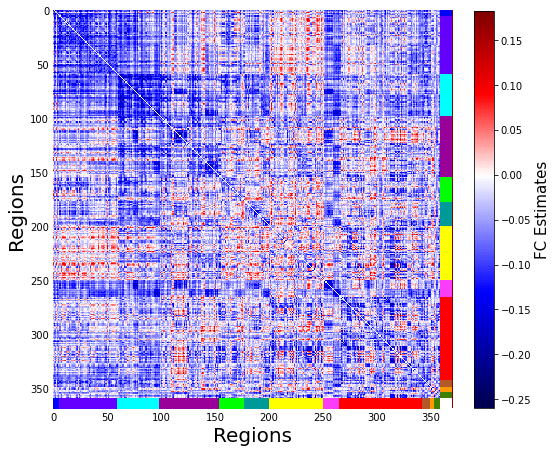

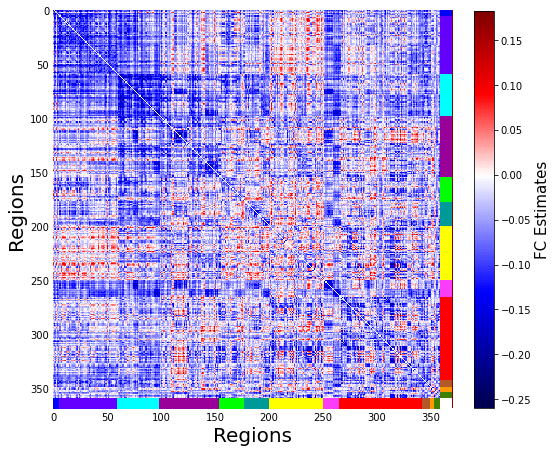

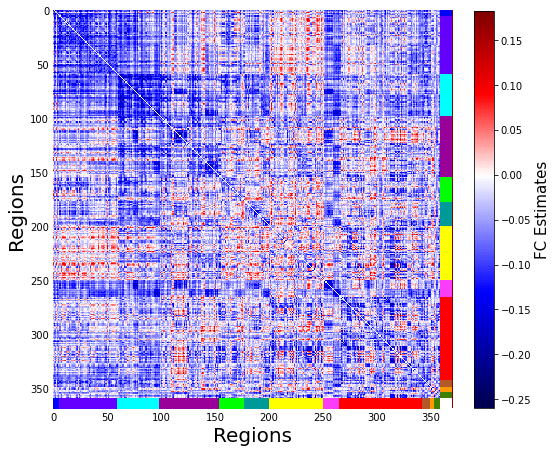

In [88]:
for i, task_name in enumerate(task_names):
    fig = actflow.tools.addNetColors(resid_rest_fcs_ave[task_name])
    figFileName = '%s_resid-rest_fc.png'%(task_name)
    fig.savefig(os.path.join(fig_dir, figFileName), bbox_inches='tight', format='png', dpi=250)